In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tikzplotlib
import math

In [3]:
#import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
#matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
#matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

In [4]:
#random.seed(1)
#np.random.seed(1)

In [5]:
#Set display options
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

In [6]:
data = pd.read_csv('../data/grad_school.csv', decimal=",", delimiter = ';')
data = data.apply(pd.to_numeric)

In [7]:
data = data.drop(['Admit','Help_1','Help_2','Help_3','Help_4','Help_5','Help_6'], axis = 1)

In [8]:
data.head()

,ID,Gender_F,Gender_M,Race_B,Race_A,Race_W,GRE_Verbal,GRE_Quant
0,1,1,0,1,0,0,149,165
1,2,1,0,0,1,0,164,159
2,3,1,0,0,0,1,140,153
3,4,0,1,1,0,0,149,156
4,5,0,1,0,1,0,153,154


In [9]:
#data = data.sample(frac=1).reset_index(drop=True)

In [10]:
data_cluster = data.drop(['ID','Gender_M','Gender_F','Race_W','Race_B','Race_A'], axis = 1)

In [90]:
#Standardize the data
#data_cluster['GRE_Verbal'] = ((data_cluster['GRE_Verbal']-data_cluster['GRE_Verbal'].mean())/data_cluster['GRE_Verbal'].std())
#data_cluster['GRE_Quant'] = ((data_cluster['GRE_Quant']-data_cluster['GRE_Quant'].mean())/data_cluster['GRE_Quant'].std())

In [11]:
data_cluster.head()

,GRE_Verbal,GRE_Quant
0,149,165
1,164,159
2,140,153
3,149,156
4,153,154


In [12]:
data_cluster_array = data_cluster.to_numpy()

In [92]:
init = np.array([[data_cluster['GRE_Verbal'].min(), data_cluster['GRE_Quant'].min()],[data_cluster['GRE_Verbal'].max(), data_cluster['GRE_Quant'].max()]],np.float64)
#init = np.array([[170, 130],[170, 130]],np.float64)
kmeans = KMeans(n_clusters=2, n_init=1, max_iter=100, init=init).fit(data_cluster_array)

In [93]:
labels = kmeans.labels_

In [94]:
#kmeans.inertia_

In [95]:
#kmeans.cluster_centers_

In [96]:
data['Cluster'] = kmeans.labels_

In [97]:
data['Cluster'].value_counts()

0    316
1    284
Name: Cluster, dtype: int64

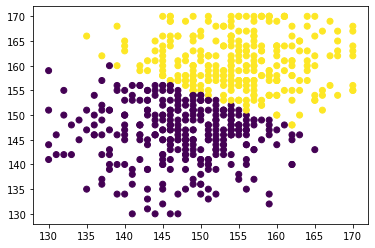

In [98]:
plt.scatter(data_cluster_array[:, 0], data_cluster_array[:, 1], c=labels)

In [99]:
#Group fairness
print(len(data[(data.Gender_F == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Cluster == 1)]))
print('---')
print(len(data[(data.Race_B == 1) & (data.Cluster == 1)]))
print(len(data[(data.Race_A == 1) & (data.Cluster == 1)]))
print(len(data[(data.Race_W == 1) & (data.Cluster == 1)]))
print('---')
print(len(data[(data.Gender_F == 1) & (data.Race_B == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_A == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_W == 1) & (data.Cluster == 1)]))
print('---')
print(len(data[(data.Gender_M == 1) & (data.Race_B == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_A == 1) & (data.Cluster == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_W == 1) & (data.Cluster == 1)]))

138
146
---
92
96
96
---
44
46
48
---
48
50
48


In [100]:
#Algorithm is splitting along the wrong hyperplane, can't expect it to split into good and bad performers with random start centroids...
#What if we set the initial cluster centers to (170,170,6) and (130,130,0)? -> Seems to work! 'Fairness Through Awareness'
#Or: We just manually optimize the distance to these points?
#Next: 1) Try on an unknown test set, 2) Use the K-Means as predictor?, 3) Train a classifier (SVM, LogReg) to that!, 4) Compare 2 and 3
#'Pareto-Fairness': Check if there are any observations, where a rejected applicant is strictly worse in the GRE scores than an accepted one (individual fairness)
#Check this set for any other form of unfairness (equalized odds etc.)

In [101]:
dist = np.linalg.norm(data_cluster_array[0]-[170,170])

In [102]:
temp = list()
for i in range(0,len(data_cluster_array)):
    dist = np.linalg.norm(data_cluster_array[i]-[170,170])
    temp.append(dist)

In [103]:
data['Distance'] = temp

In [104]:
alpha = 0.5

In [105]:
data = data.sort_values(by=['Distance'])
data = data.reset_index(drop=True)

In [106]:
temp = list()
cutoff = math.ceil(len(data)*alpha)
for i in range(0,len(data)):
    if (i<cutoff):
        temp.append(1)
    else:
        temp.append(0)
    

In [107]:
data['Admit'] = temp

In [108]:
data_admit = data[data['Admit']==1]
data_reject = data[data['Admit']==0]

Text(0, 0.5, 'GRE Quantitative Reasoning')

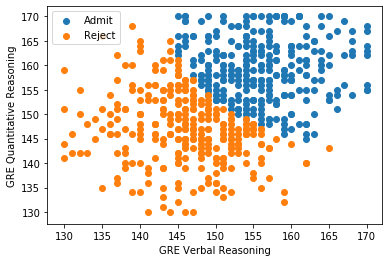

In [109]:
plt.scatter(data_admit['GRE_Verbal'], data_admit['GRE_Quant'], label='Admit')
plt.scatter(data_reject['GRE_Verbal'], data_reject['GRE_Quant'], label='Reject')
plt.legend(loc="upper left")
#plt.title(r'$\alpha=0.5$')
plt.xlabel('GRE Verbal Reasoning')
plt.ylabel('GRE Quantitative Reasoning')
#tikzplotlib.save('alpha5perc.tex')

In [110]:
#Group fairness
print(len(data[(data.Gender_F == 1) & (data.Race_B == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_A == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_F == 1) & (data.Race_W == 1) & (data.Admit == 1)]))
print('---')
print(len(data[(data.Gender_M == 1) & (data.Race_B == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_A == 1) & (data.Admit == 1)]))
print(len(data[(data.Gender_M == 1) & (data.Race_W == 1) & (data.Admit == 1)]))

45
51
51
---
51
55
47
